### Initialize

In [1]:
# Define Program Version 
__ver__ = '01'

In [2]:
# Bunch of imports 
import therpy as tp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline
import pandas as pd
import bec1db as bec1db_package
import warnings
from tqdm import tqdm_notebook as tqdm
warnings.filterwarnings("ignore")
import scipy.special
import os.path
import pickle
import ipywidgets as widgets
from IPython.display import display

cst = tp.cst(sigmaf=0.5)
kHz = cst.h * 1e3
twopi = np.pi * 2
bec1db = bec1db_package.Tullia(delta=20)

Updating the local database...
Done


In [3]:
# Bunch of functions 

def lorentzian_fitfun(f, f0, gamma, amp=1, offset=0):
    return amp * (gamma/2)**2 / ((f-f0)**2 + (gamma/2)**2) + offset

def gaussian(x, x0, sigma, amp, offset=0): return offset + amp*np.exp(- (x-x0)**2 / (2*sigma**2))

def bin_data(xi, yi):
    x = np.unique(xi)
    y = [None] * x.size
    for i in range(x.size): y[i] = yi[xi == x[i]]
    # Return 
    y_mean = np.array([a.mean() for a in y])
    y_err = np.array([np.std(a) / (a.size**0.5) for a in y])
    return (x, y_mean, y_err, y, xi, yi)

# returns rabi in kHz
@np.vectorize
def volt2rabi(volt):
    if volt < 0.1 or volt > 5:
        return 0
    volt = np.log10(volt)
    dbm = 1.5863 +0.2211*volt -0.1022*volt**2 -0.1301*volt**3 -0.0862*volt**4 +0.2323*volt**5 +0.1624*volt**6 -0.1552*volt**7 -0.1206*volt**8
    dbm = 10**dbm
    sqrtpwr = (10**((dbm-30)/10))**(1/2)
    return -0.0332 +0.5832*sqrtpwr -0.0167*sqrtpwr**2

from scipy.optimize import brentq
# Provide rabi in kHz
@np.vectorize
def rabi2volt(rabi):
    if rabi <= volt2rabi(0.1) or rabi >= volt2rabi(5):
        print('outside valid range')
        return 0
    def funSolve(v):
        return rabi - volt2rabi(v)
    return brentq(funSolve, 0.1, 5)
def meshgrid(xLen=10, yLen=10, data=None):
    if data is not None: yLen, xLen = data.shape
    return np.meshgrid(np.arange(xLen, dtype=np.float), np.arange(yLen, dtype=np.float))
def gaussian_2d(x, y, cx=1, cy=1, sx=1, sy=1, amp=1, offset=0, angle=0):
    x, y = x - cx, y - cy
    sx, sy = 2*sx**2, 2*sy**2
    a = angle * np.pi / 180
    xp, yp = x*np.cos(a) + y*np.sin(a), - x*np.sin(a) + y*np.cos(a)
    return offset + amp * np.exp(-xp**2/sx - yp**2/sy)
    
def gaussian_2d_guess(data, x=None, y=None):
    if x is None: x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
    t = np.sum(data)
    cx, cy = np.sum(data * x) / t, np.sum(data * y) / t
    sx, sy = (np.sum(data * (x-cx)**2) / t)**(1/2), (np.sum(data * (y-cy)**2) / t)**(1/2)
    return (cx, cy, sx, sy, data[int(cy), int(cx)], np.mean(data)/5, 0.0)
    
def fit_gaussian_2d(data, guess=None, plot=False):
    if guess is None: guess = gaussian_2d_guess(data)
    fr = tp.optimize.surface_fit(data, fun=gaussian_2d, guess=guess, show=plot)
    return fr
def gaussian_2d_integral(data, nsigma, fr=None, ideal=False, plot=False, guess=None, return_mask=False):
    if fr is None: fr = fit_gaussian_2d(data, guess=guess)
    # Generate the fitted data
    x, y = meshgrid(data=data)
    fit_data = gaussian_2d(x, y, *fr)
    amp = 1 if len(fr) <= 4 else fr[4]
    offset = 0 if len(fr) <= 5 else fr[5]
    # Ideal case
    if ideal:
        return np.sum(fit_data - offset)
    # Data case
    threshhold = np.exp(- nsigma**2/2) * amp + offset
    mask = fit_data >= threshhold
    # Plot
    if plot:
        plt.figure()
        plt.imshow(data)
        fit_data[~mask] = 0
        plt.imshow(mask, alpha=0.2, cmap='gray')
    
    # Mask return
    if return_mask:
        return mask
    
    return np.sum(data[mask])

''' 
Copy image names from clipboard and get parameters 
df : if you want to add on to the older df
init : initialize and return empty df
var : list of strings (variable names) that you want to retrive from database
x_var : a string (variable name), available as df.x
image_func : either tp.Image or tp.Hybrid_Image
using : 0=TopA only, 1=TopB only, 2=All Images
'''
def get_from_clipboard(df=None, init=False, var=None, x_var=None, image_func=tp.Image, using=2, display=False):
    # If initializing, then return empty dataframe
    if init: return pd.DataFrame(columns=['name','image'])
    
    # If df is None, make an empty one
    if df is None: 
        df = pd.DataFrame(columns=['name','image'])
    
    # Get the copied image names
    pasted = pd.read_clipboard(header=None, names=['name'])['name'].tolist()
    
    # Filter for using 0:TopA only, 1:TopB only, 2:all
    if using==0:
        pasted_filtered = [p for p in pasted if p[-1]=='A']
    elif using==1:
        pasted_filtered = [p for p in pasted if p[-1]=='B']
    else:
        pasted_filtered = [p for p in pasted]
    
    # Add it to df if not already in there
    names = df.name.tolist()
    for n in tqdm(pasted_filtered, desc='Loading'):
        if n not in names:
            df.loc[df.shape[0]] = n
            df.image[df.shape[0]-1] = image_func(name=n)
    
    # sort in time
    df.sort_values('name', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # Get Parameters
    try: bec1db.refresh()
    except: pass
    df['shot'] = np.linspace(0,df.shape[0]/2-0.5,df.shape[0])
    if x_var is not None:
        df['x'] = bec1db.image_query(df.name.tolist(), [x_var])[x_var]
    if type(var) is str:
        df[var] = bec1db.image_query(df.name.tolist(), [var])[var]
    elif type(var) is list:
        _ = bec1db.image_query(df.name.tolist(), var)
        for n in var:
            df[n] = _[n]
    
    # Print Information
    if display:
        print('Pasted Sample : ', pasted[0:2])  
        print('Newly added images       : {}'.format(df.shape[0]- len(names)))
        print('Total number of images   : {}'.format(df.shape[0]))
    
    # return
    return df


def get_roi(data, center=[0,0], width=100, height=100):
    center = (data.shape[1]//2 + center[0], data.shape[0]//2 + center[1])
    return tp.imagedata.get_cropi(data, center=center, width=width, height=height)

def atom_num_filter(df_, keep = 0.15, offset = 0.0, plot=True):
    # Prepare
    if plot: fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
    if plot: ax[0].plot(df_['shot'], df_['total_atoms']/1e6,'.-', label='All')
    shapes = [df_.shape]
    
    # Filter
    median_numbers = np.median(df_.total_atoms)
    offset += 1
    using = (df_.total_atoms.values > median_numbers*(offset-keep)) & (df_.total_atoms.values <= median_numbers*(offset+keep))
    bad = df_[~using] 
    df_ = df_[using]
    df_.reset_index(inplace=True, drop=True)
    shapes.append(df_.shape)
    if plot: ax[0].plot(bad['shot'], bad['total_atoms']/1e6, 'rx', label='Atom Num Filter')
    if plot: ax[0].axhline(median_numbers/1e6, linestyle='--', color='k', alpha=0.5)

    if plot: 
        # Plot
        median_numbers = np.median(df_.total_atoms)
        ax[1].plot(df_['shot'], df_['total_atoms']/median_numbers,'o-')
        ax[1].axhline(1, linestyle='--', color='k', alpha=0.5)

        ax[0].legend()
        ax[0].set(title = 'Atom number stability', xlabel= 'Shot Number ~ Time', ylabel='Atom Numbers [M]')
        ax[1].set(title = 'Median Atom Num {:.2f} M'.format(median_numbers/1e6), xlabel= 'Shot Number ~ Time', ylabel='Atom Numbers [median]')
        plt.tight_layout()

        # Relevant Information
        print('''
        Total Loaded Images {}
        Atom Num Filter     {}
        Removed Images      {}
        '''.format(shapes[0][0], shapes[1][0], shapes[0][0]-shapes[1][0]))
    
    return using

def erf(x, x0, sigma, amp=1):
    return amp * scipy.special.erf((x-x0)/(2**0.5 * sigma))

def mesh_for_2d_plot(x, y, z):
    x1 = np.concatenate([ [2*x[0] - x[1]], x])
    x2 = np.concatenate([x, [2*x[-1] - x[-2]]])
    x = np.mean([x1, x2], axis=0)

    y1 = np.concatenate([ [2*y[0] - y[1]], y])
    y2 = np.concatenate([y, [2*y[-1] - y[-2]]])
    y = np.mean([y1, y2], axis=0)
    
    return (x, y, z)

In [4]:
# Useful snippets 

default_settings = dict(
   # Image Preparation and Background 
   center_x=1110, center_y=1314, width=800, height=1000, 
   subsample=3, rotate=0, bg_width=20, bg_order=1, bad_light=0,

   # Physical Parameters
   Isat=77, time=10, pixel=0.7e-6, sigmaf=0.5, trap_f=23.9,
   od_method='table', fudge=1, ellipticity=1,
   
   # Hybrid Preparation
   xsec_extension='default', xsec_slice_width=4, 
   xsec_fit_range=1.75, radial_selection=0.5,
   
   # Hybrid Thermometry
   kind='unitary', Tfit_lim=0.06, Tfit_guess_kT=3, Tfit_guess_mu0=0, 
   
   # Other
   memory_saver=True, )



In [5]:
# Fermi Gas Classes 

# Import statements and useful functions 
import numpy as np
import pandas as pd
import therpy as tp
import scipy.optimize
import scipy.interpolate
import os.path
import os
import urllib.request

###### Parameters
cst_FG = tp.cst()
cst_FG.c1 = ((cst_FG.twopi * cst_FG.hbar**2)/(cst_FG.mass))**(1/2)
cst_FG.c2 = 1.0/(6*cst_FG.pi**2) * (2*cst_FG.mass/cst_FG.hbar**2)**(3/2)
cst_FG.virial_coef = [1.0, 3.0*2**(1/2)/8, -0.29095295, 0.065]
cst_FG.Critical_Temperature_TF = 0.17
cst_FG.xi = 0.37
cst_FG.xi_n = 0.45
def thermal_wavelength(kT):
    return cst_FG.c1 / (kT)**(1/2)
###### Ideal Gas
@np.vectorize
def density_ideal(kT, mu):
    if kT == 0:
        if mu <= 0:
            print('Density is undefined for negative mu and zero temperature')
            return 0.0
        return cst_FG.c2 * (mu)**(3/2)
    return thermal_wavelength(kT)**(-3) * tp.FermiFunction(m=3/2, logz=mu/kT)
@np.vectorize
def pressure_ideal(kT, mu):
    if kT == 0:
        return 2/5*density_ideal(0, mu)*mu
    return kT/thermal_wavelength(kT)**3 * tp.FermiFunction(m=5/2, logz=mu/kT)
@np.vectorize
def TTF_to_betamu_ideal(TTF, a=-10000, b=100):
    if TTF <= 0.01: return 1/TTF # Zero T approximation
    def minimizer(mu): return TTF - (cst_FG.h / cst_FG.n2EF(density_ideal(cst_FG.h, mu*cst_FG.h))) # Fix kT to 1 Hz and find mu in Hz (=betamu)
    return scipy.optimize.brentq(minimizer, a, b)   
@np.vectorize
def entropy_NkB_ideal(kT, mu):
    if kT == 0: return 0.0
    return (5/2 * tp.FermiFunction(m=5/2, logz=mu/kT) / tp.FermiFunction(m=3/2, logz=mu/kT)) - mu/kT
@np.vectorize
def entropy_NkB_TTF_ideal(TTF):
    if TTF == 0: return 0.0
    return entropy_NkB_ideal(cst_FG.h, TTF_to_betamu_ideal(TTF) * cst_FG.h)
###### Virial Gas
@np.vectorize
def density_virial(kT, mu):
    if kT == 0:
        return 0.0
    return kT / thermal_wavelength(kT)**3 * (cst_FG.virial_coef[0]*1/kT*np.exp(1*mu/kT) + cst_FG.virial_coef[1]*2/kT*np.exp(2*mu/kT) + cst_FG.virial_coef[2]*3/kT*np.exp(3*mu/kT) + cst_FG.virial_coef[3]*4/kT*np.exp(4*mu/kT) )
@np.vectorize
def pressure_virial(kT, mu):
    if kT == 0:
        return 0.0
    return kT / thermal_wavelength(kT)**3 * (cst_FG.virial_coef[0]*np.exp(1*mu/kT) + cst_FG.virial_coef[1]*np.exp(2*mu/kT) + cst_FG.virial_coef[2]*np.exp(3*mu/kT) + cst_FG.virial_coef[3]*np.exp(4*mu/kT) )

# Ideal Fermi Gas definition 
'''
Ideal Fermi Gas
    - functions to relate various Thermodynamic quantities

Methods
    - thermal_wavelength
    - density
    - pressure
    - TTF_to_betamu
    - entropy_NkB
    - entropy_NkB_TTF

Dataframe contains links between. Note that E = 3/2 PV
    - T/T_F
    - mu/E_F
    - P/P0 = E/E0
    - k/k0
    - Cv/Nk
    - S/Nk
'''
class Ideal_Fermi_Gas:
    def __init__(self, pts=1000, TTF_max = 200, TTF_min=0.05):
        # Define dataframe for fast computation
        kT = 1 * cst_FG.h
        mu = np.concatenate([np.linspace(self.TTF_to_betamu(TTF_max), 5, pts//10*9)[:-1], np.linspace(5, self.TTF_to_betamu(TTF_min), pts//10)]) * cst_FG.h
        n = self.density(kT, mu)
        P = self.pressure(kT, mu)
        EF = cst_FG.n2EF(n)
        P0 = self.pressure(0, EF)
        c1 = tp.Curve(x=mu, y=EF)
        df_ideal = pd.DataFrame(data=dict(betamu=mu/kT))
        df_ideal['T/T_F'] = kT / EF
        df_ideal['mu/E_F'] = mu / EF
        df_ideal['P/P0'] = P / P0
        df_ideal['k/k0'] = c1.diff(method='central2').y
        df_ideal['Cv/Nk'] = 3/2 * 1/df_ideal['T/T_F'] * (df_ideal['P/P0'] - 1/df_ideal['k/k0'])
        df_ideal['S/Nk'] = 1/df_ideal['T/T_F'] * (df_ideal['P/P0'] - df_ideal['mu/E_F'])
        self.df = df_ideal
    
    # Various functions
    def thermal_wavelength(self, kT): return thermal_wavelength(kT)
    def density(self, kT, mu): return density_ideal(kT, mu)
    def pressure(self, kT, mu): return pressure_ideal(kT, mu)
    def TTF_to_betamu(self, TTF, a=-10000, b=100): return TTF_to_betamu_ideal(TTF, a, b)
    def entropy_NkB(self, kT, mu): return entropy_NkB_ideal(kT, mu)
    def entropy_NkB_TTF(self, TTF): return entropy_NkB_TTF_ideal(TTF)

# Virial Fermi Gas Definition 
'''
Fermi Gas, Virial Expansion
'''
class Virial_Fermi_Gas:
    def __init__(self, TTF_max = 200, TTF_min=0.5):
        # Generate dataframe
        kT = 1 * cst_FG.h
        mu = np.linspace(TTF_to_betamu_ideal(TTF_max), TTF_to_betamu_ideal(TTF_min), 10000) * cst_FG.h
        n = self.density(kT, mu)
        P = self.pressure(kT, mu)
        EF = cst_FG.n2EF(n)
        P0 = pressure_ideal(0, EF)
        c1 = tp.Curve(x=mu, y=EF)
        df_virial = pd.DataFrame(data=dict(betamu=mu/kT))
        df_virial['T/T_F'] = kT / EF
        df_virial['mu/E_F'] = mu / EF
        df_virial['P/P0'] = P / P0
        df_virial['k/k0'] = c1.diff(method='central2').y
        df_virial['Cv/Nk'] = 3/2 * 1/df_virial['T/T_F'] * (df_virial['P/P0'] - 1/df_virial['k/k0'])
        self.df = df_virial
        
    # Various functions
    def thermal_wavelength(self, kT): return thermal_wavelength(kT)
    def density(self, kT, mu): return density_virial(kT, mu)
    def pressure(self, kT, mu): return pressure_virial(kT, mu)
    

# Unitary Fermi Gas using Mark's EoS 
'''
Mark's equation of state
'''
class Unitary_Fermi_Gas: 
    def __init__(self,):
        # Download the data if not already
        p_ = tp.getpath('Projects','Data','EoS','UnitaryFermiGasExperiment_kPEoS.csv')
        if not os.path.isfile(p_):
            print("Downloading Database -- Might take some time!")
            url = 'https://www.dropbox.com/s/8irmfrn2zdvfgba/UnitaryFermiGasExperiment_kPEoS.csv?dl=1'
            u = urllib.request.urlopen(url)
            data = u.read()
            u.close()
            # Create folder
            os.makedirs(os.path.split(p_)[0], exist_ok=True)
            with open(p_, "wb") as f :
                f.write(data)
        
        # Load Data
        self.df = pd.read_csv(p_)
        
        # Interpolated Density Data
        x = np.array(self.df['T/T_F'])
        y = np.array(self.df['mu/E_F'])
        VFG = Virial_Fermi_Gas()
        c = tp.Curve(x = np.array(VFG.df['T/T_F']), y = np.array(VFG.df['mu/E_F'])).sortbyx().trim(xlim=[np.max(x),np.max(x)+0.1])
        muEF_curve = tp.Curve(x = np.concatenate([[0], x, c.x]), y = np.concatenate([[cst_FG.xi], y, c.y]))
        TTF = np.linspace(0, muEF_curve.maxx, 10000)
        muEF = muEF_curve(TTF)
        c_muEF_extension = tp.Curve(TTF, muEF)
        density_c_low = scipy.interpolate.interp1d(x = TTF / muEF, y = muEF)
        density_c_high = scipy.interpolate.interp1d(x = muEF[1:] / TTF[1:], y = muEF[1:])
        self.density_c_low = density_c_low
        self.density_c_high = density_c_high
        self.density = np.vectorize(self.density_single)
        
        # Interpolated Energy Data
        IFG = Ideal_Fermi_Gas()
        c1 = tp.Curve(np.array(self.df['T/T_F']), np.array(self.df['E/E0'])) # Mark EoS E/E0 vs T/T_F
        c2 = tp.Curve(np.array(IFG.df['T/T_F']), np.array(IFG.df['P/P0'])).trim(xlim=[c1.maxx + 0.2, np.inf]) # Ideal Fermi Gas E/E0 = P/P0 vs T/T_F, from end of Mark EoS to end with some padding for smooth transition
        energy_c = scipy.interpolate.interp1d(x = np.concatenate([[0], c1.x, c2.x]), y = np.concatenate([[cst_FG.xi], c1.y, c2.y+(cst_FG.xi_n-1)]))
        self.energy_c = energy_c
        self.IFG = IFG
        self.E_E0 = np.vectorize(self.E_E0_single)
        
    # Various functions
    def density_single(self, kT, mu):
        # Zero T
        if kT == 0:
            return cst_FG.EF2n(mu/cst_FG.xi, neg=True)
        if mu/kT > 4:
            return cst_FG.EF2n(mu / self.density_c_low(kT/mu), neg=True)
        if mu/kT > -0.5:
            return cst_FG.EF2n(mu / self.density_c_high(mu/kT), neg=True)
        return density_virial(kT, mu)
    
    def density_hybrid(self, z, kT, mu, trapf=23.9):
        return self.density(kT, mu - 1/2 * cst_FG.mass * (2*np.pi*trapf)**2 * z**2)
    
    def E_E0_single(self, TTF):
        if TTF < self.energy_c.x.max():
            return self.energy_c(TTF)
        else:
            # Compute using IFG
            # betamu = self.IFG.TTF_to_betamu(TTF)
            # return (self.IFG.pressure(cst_FG.h, betamu * cst_FG.h) / self.IFG.pressure(0, betamu * cst_FG.h)) + (cst_FG.xi_n-1)
            return self.energy_c.y[-1]

# Make objects
IFG = Ideal_Fermi_Gas()
VFG = Virial_Fermi_Gas()
UFG = Unitary_Fermi_Gas()

# Special Functions
def hybrid_E_N(kT, mu, trapf=23.9, simple=True, nz = None):
    u_ = 1/2 * cst_FG.mass * (2*np.pi*trapf)**2
    if nz is None:
        n_0 = UFG.density(kT, mu)
        z_max = 0
        while True:
            z_max += 50e-6
            if UFG.density(kT, mu - u_*z_max**2) <= n_0 / 1e6: break
        z = np.linspace(-z_max, z_max, z_max*1e6 * 4)
        n = UFG.density(kT, mu - u_* z**2)
    else:
        z = nz.x
        n = nz.y
        
    if simple: # If simple, then simply return 4 * <U>
        return 4 * np.trapz(u_*z**2 * n, z) / np.trapz(n, z)
    
    # Compute total E_int + U energy
    EF = cst_FG.n2EF(n)
    TTF = kT / EF
    E_N_z = UFG.E_E0(TTF) * 3/5 * EF
    E_N = (np.trapz(E_N_z * n, z) + np.trapz(u_*z**2 * n, z)) / np.trapz(n, z)
    return E_N



# In Situ Density Modulation

In [422]:
# Some Fitting functions 
import scipy.special
def erf(x, x0, sigma, amp=1):
    return amp * scipy.special.erf((x-x0)/(2**0.5 * sigma))
def fitfun_erf(x, x1, x2, s1, s2, amp=1, offset=0, slope=0):
    y = erf(x, x1, s1) + erf(-x, -x2, s2)
    return y*amp/2 + offset + slope*x

In [423]:
# Desplay widgets to select various parameters 

# All the variables to load 
var = ['ExpansionTime','SideGreenEvap','WaitBox',
       'IREvap','HeatTime','ShakeTime','ShakeWait', 'HeatCycles',
       'ShakingCycles', 'BoxShakeFreq','BoxShakeAmp','BoxShakeTime']

fontsize = 15

# Saving and Loading widgets 
WID_SaveAnalyzedDataBtn = widgets.Button( description='Save Data', button_style='success', )
WID_Folder = widgets.Text( value='AnalyzedData', placeholder='Type Folder to store data', description='Save Folder :')
WID_DatasetType = widgets.Text( value='InsituShakingVsFreq', placeholder='Type Dataset Type/Information', description='Dataset Type :',)
WID_DatasetDate = widgets.Text( value='06_22_2017', placeholder='Type Dataset Date, E.x. 06_15_2017', description='Dataset Date :',)
WID_DatasetName = widgets.Text( value='DS3', placeholder='Type Dataset Name, E.x. DS1', description='Dataset Name :',)

# Select a Particular x_variable
WID_x_var = widgets.ToggleButtons(description='x variable = = > ', 
            options=['ShakeWait', 'ShakingCycles', 'BoxShakeFreq', 'BoxShakeAmp', 'HeatCycles'])
display(WID_x_var)

# Select a Particular x_variable
WID_using_image = widgets.ToggleButtons(description='Image Selection = = > ', 
            options=['A', 'B', 'Both'])
display(WID_using_image)

# Select a Particular X_Label for the plots 
WID_xlabel = widgets.ToggleButtons(description='xlabel for plots = > ', 
            options=['Waittime (ms)', 'Shaking Cycles', 'Shaking Frequency (Hz)', 'Shaking Amplitude (Cicero Volts)', 'Heating Cycles'])
display(WID_xlabel)

# Reduced Plots and Info for Faster Processing 
WID_info = widgets.Checkbox( value=True, description='Show all info plots',)
display(WID_info)

# Additional WID used later 
WID_atoms_keep = widgets.FloatSlider(value=0.1, min=0.01, max=0.4, step=0.01,
                description='Atom Num Selection:', readout=True, readout_format='.2f',
                layout=widgets.Layout(width='50%'), )

WID_height = widgets.IntSlider(value=181, min=105, max=219, step=2,
             description='Height:', readout=True, layout=widgets.Layout(width='50%'), )

WID_width = widgets.IntSlider(value=75, min=15, max=177, step=2,
             description='Width:', readout=True, layout=widgets.Layout(width='50%'), )

WID_center_x = widgets.IntSlider(value=0, min=-30, max=30, step=1,
             description='Center X:', readout=True, layout=widgets.Layout(width='50%'), )

WID_center_y = widgets.IntSlider(value=0, min=-30, max=30, step=1,
             description='Center Y:', readout=True, layout=widgets.Layout(width='50%'), )

WID_clim_dN = widgets.FloatSlider(value=0.15, min=0.01, max=0.50, step=0.001,
                description='clim for dN:', readout=True, readout_format='.3f',
                layout=widgets.Layout(width='50%'), )

WID_clim_dN_N = widgets.FloatSlider(value=0.15, min=0.01, max=0.5, step=0.001,
                description='clim for dN/N:', readout=True, readout_format='.3f',
                layout=widgets.Layout(width='50%'), )

In [462]:
# ONLY ONCE -- Initialize empty dataframe and select options 
df_all = get_from_clipboard(init=True)

## Load Data from Images

In [463]:
# Import from Clipboard 
x_var = WID_x_var.value
using = 0 if WID_using_image.value == 'A' else 1 if WID_using_image.value == 'B' else 2
info = WID_info.value
df_all = get_from_clipboard(df=df_all, init=False, var=var, x_var=x_var, image_func=tp.Image, using=using, display=info)
if WID_info.value:
    df_all.head(5)


Updating the local database...
Done
Pasted Sample :  ['07-18-2017_01_32_09_TopA', '07-18-2017_01_32_09_TopB']
Newly added images       : 23
Total number of images   : 23


07-18-2017_01_11_25_TopA
0.0


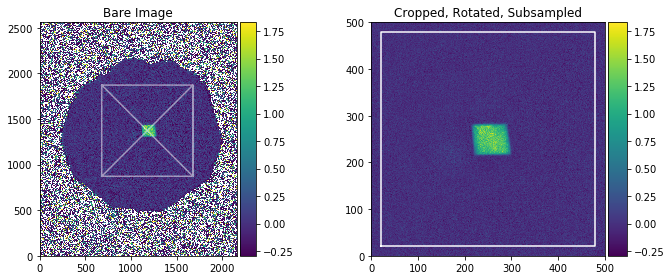

In [464]:
# Define Settings 
# settings = {**default_settings, 
#             **dict(center_x = 1150, center_y = 1307, width=1000, height=1000, fudge=1.73)}

settings = {**default_settings, 
            **dict(center_x = 1180, center_y = 1372, width=1000, height=1000, fudge=1.73, subsample=2)}

# Apply settings
for i, r in df_all.iterrows():
    r.image.set(**settings)
    
# Tests
if WID_info.value: 
    test = 0
    print(df_all.image.iloc[test].name)
    df_all.image.iloc[test].plot_crop()
    print(df_all.x.iloc[test])


All Images 23; Data 12; BG 11
Fudge   1.73
Volume  1000289 um^3
Atom #  0.371 +- 0.010 
Density 0.371 +- 0.010 um^-3
E_F     6.59 +- 0.12 kHz
v_F     29.56 um/ms


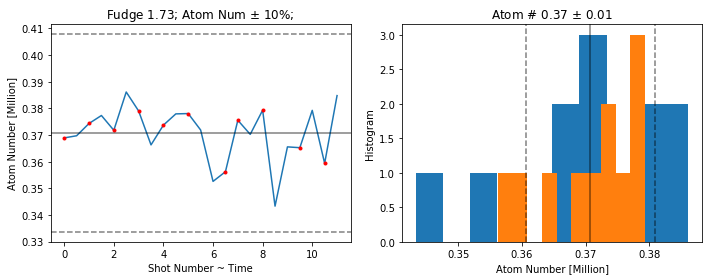

In [465]:
# Atom numbers filter, sort data and bg, print information 

# Parameters 
display(WID_atoms_keep)

df_all['total_atoms'] = [im.total_atoms for im in tqdm(df_all.image, desc='Atoms')]
using = atom_num_filter(df_all, keep=WID_atoms_keep.value, offset=0.0, plot=False)

# Extract data and background 
bg_select = ['ShakingCycles', 0]
df_data = df_all[(df_all[bg_select[0]] != 0) & using]
df_bg = df_all[(df_all[bg_select[0]] == 0) & using]
df_bad = df_all[~using]

# Extract relavant information 
info = {}
info['Images Data'] = df_data.shape[0]
info['Images BG'] = df_bg.shape[0]
info['Fudge'] = df_data.image.iloc[0].fudge
info['Atoms'] = np.mean(df_all[using].total_atoms)
info['Atoms Error'] = np.std(df_all[using].total_atoms)
info['Volume'] = 98e-6 * np.pi * (57e-6)**2
info['Density'] = info['Atoms'] / info['Volume']
info['Density Error'] = info['Atoms Error'] / info['Volume']
info['EF'] = np.mean(cst.n2EF(df_all[using].total_atoms / info['Volume']))
info['EF Error'] = np.std(cst.n2EF(df_all[using].total_atoms / info['Volume']))
info['vF'] = ((2 * info['EF']) / (cst.mass))**(1/2)

print('All Images {}; Data {}; BG {}'.format(df_all.shape[0], df_data.shape[0], df_bg.shape[0]))
print('Fudge  ', info['Fudge'])
print('Volume  {:.0f} um^3'.format(info['Volume']*1e18))
print('Atom #  {:.3f} +- {:.3f} '.format(info['Atoms']/1e6, info['Atoms Error']/1e6))
print('Density {:.3f} +- {:.3f} um^-3'.format(info['Density']/1e18, info['Density Error']/1e18))
print('E_F     {:.2f} +- {:.2f} kHz'.format(info['EF']/kHz, info['EF Error']/kHz))
print('v_F     {:.2f} um/ms'.format(info['vF'] * 1e3))

if WID_info.value: 
    fig, ax = plt.subplots(ncols=2, figsize=[10, 4])
    ax[0].plot(df_all.shot, df_all.total_atoms/1e6, '-', 
               df_bad.shot, df_bad.total_atoms/1e6, 'rx',
               df_bg.shot, df_bg.total_atoms/1e6, 'r.')
    ax[0].axhline(info['Atoms'] / 1e6, linestyle='-', c='k', alpha=0.5)
    ax[0].axhline(info['Atoms'] / 1e6 * (1 + WID_atoms_keep.value), linestyle='--', c='k', alpha=0.5)
    ax[0].axhline(info['Atoms'] / 1e6 * (1 - WID_atoms_keep.value), linestyle='--', c='k', alpha=0.5)
    ax[0].set(xlabel='Shot Number ~ Time', ylabel='Atom Number [Million]', 
              title='Fudge {}; Atom Num $\pm$ {:.0f}%;'.format(info['Fudge'], WID_atoms_keep.value*100))
    ax[1].hist(df_data.total_atoms/1e6)
    ax[1].hist(df_bg.total_atoms/1e6)
    ax[1].axvline(info['Atoms'] / 1e6, linestyle='-', c='k', alpha=0.5)
    ax[1].axvline(info['Atoms'] / 1e6 + info['Atoms Error']/1e6, linestyle='--', c='k', alpha=0.5)
    ax[1].axvline(info['Atoms'] / 1e6 - info['Atoms Error']/1e6, linestyle='--', c='k', alpha=0.5)
    ax[1].set(xlabel='Atom Number [Million]', ylabel='Histogram', title='Atom # {:.2f} $\pm$ {:.2f}'.format(info['Atoms']/1e6, info['Atoms Error']/1e6))
    plt.tight_layout()
    plt.show()


Box Length from Fit : 90.18 um


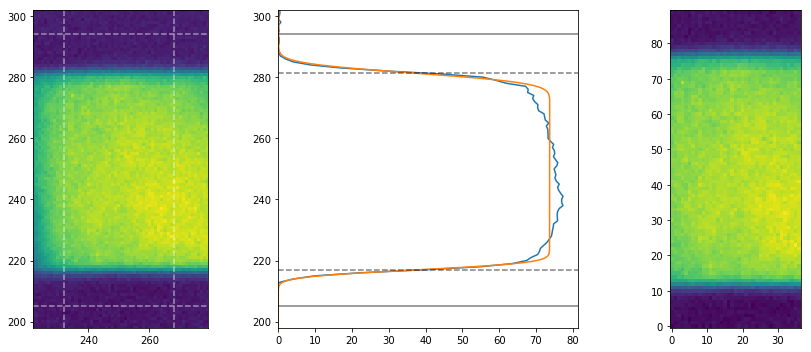

In [466]:
# roi settings and trap center 
display(WID_height)
display(WID_width)
display(WID_center_x)
display(WID_center_y)

width = WID_width.value // settings['subsample']
height = WID_height.value // settings['subsample']
center = [WID_center_x.value // settings['subsample'],WID_center_y.value // settings['subsample']]
plot_buffer = [10, 7]
roi = get_roi(data=df_bg.image.iloc[0].app, center=center, width=width, height=height)

# Average all BG images
bg_app = np.nanmean([im.app for im in df_bg.image], axis=0)
bg_curve = tp.Curve(y = np.mean(bg_app[:,roi[1]], axis=1))

# Trap Center and Box Length Fits 
guess_width = 100e-6 / df_bg.iloc[0].image.pixel_binned 
guess_sigma = 10e-6 / df_bg.iloc[0].image.pixel_binned 
guess = [bg_curve.maxx//2 - guess_width, bg_curve.maxx//2 + guess_width, 
         guess_sigma, guess_sigma, bg_curve.maxy, bg_curve.y[0], bg_curve.y[0]/bg_curve.maxx]
fr, fe = bg_curve.fit(fitfun_erf, guess, plot=False)
box_center = np.mean([fr[1], fr[0]])
box_length = abs(fr[1] - fr[0])
info['Box Length Fit'] = box_length * df_bg.iloc[0].image.pixel_binned 
print('Box Length from Fit : {:.2f} um'.format(info['Box Length Fit'] * 1e6))


# Plot
fig, ax = plt.subplots(ncols=3, figsize=[13, 5])
ax[0].imshow(bg_app, origin=0)
ax[0].axhline(roi[0].start, c='w', linestyle='--', alpha=0.5)
ax[0].axhline(roi[0].stop-1, c='w', linestyle='--', alpha=0.5)
ax[0].axvline(roi[1].start, c='w', linestyle='--', alpha=0.5)
ax[0].axvline(roi[1].stop-1, c='w', linestyle='--', alpha=0.5)
ax[0].set(xlim=[roi[1].start - plot_buffer[0], roi[1].stop + plot_buffer[0]], 
          ylim=[roi[0].start - plot_buffer[1], roi[0].stop + plot_buffer[1]])
ax[1].plot(bg_curve.y, bg_curve.x)
ax[1].plot(bg_curve.xyfitplot[1], bg_curve.xyfitplot[0])
ax[1].axhline(roi[0].start, c='k', linestyle='-', alpha=0.5)
ax[1].axhline(roi[0].stop-1, c='k', linestyle='-', alpha=0.5)
ax[1].axhline(fr[0], c='k', linestyle='--', alpha=0.5)
ax[1].axhline(fr[1], c='k', linestyle='--', alpha=0.5)
ax[1].set(ylim=[roi[0].start - plot_buffer[1], roi[0].stop + plot_buffer[1]], xlim=[0, None])
ax[2].imshow(bg_app[roi], origin=0)
plt.tight_layout()

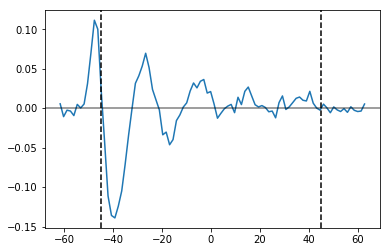

In [467]:
# Generate 1D density for all, and normalize mean of values so the peak is around 1 

# Controllers for clim
display(WID_clim_dN)
display(WID_clim_dN_N)

# Function to calculate 1d density from cropped app 
def calc_1d_profile(app):
    y = np.nanmean(app, axis=1)
    return y / np.mean(y)

# Calculate 1D profile for all images 
df_data['profile'] = [calc_1d_profile(im.app[roi]) for im in df_data.image]
df_bg['profile'] = [calc_1d_profile(im.app[roi]) for im in df_bg.image]
bg_profile = np.mean(df_bg.profile, axis=0)

# Create 2D movie 
x = np.unique(df_data.x)
y = (np.arange(df_data.iloc[0].image.app.shape[0])[roi[0]] - box_center) * df_data.image.iloc[0].pixel_binned * 1e6
z_difference = np.array([np.mean([p for p in df_data.profile[df_data.x == xi]], axis=0) - bg_profile for xi in x]).T
z_percent = np.array([(np.mean([p for p in df_data.profile[df_data.x == xi]], axis=0) - bg_profile)/bg_profile for xi in x]).T
movie_dN = [x, y, z_difference]
movie_dN_N = [x, y, z_percent]

# Plot 
clim = 0.20
cmap = 'bwr' # viridis, bwr

if len(x) > 1:
    fig = plt.figure(figsize=[20, 10])
    plt.subplot(211)
    plt.pcolormesh(*mesh_for_2d_plot(*movie_dN), vmin=- WID_clim_dN.value , vmax=WID_clim_dN.value, cmap=cmap)
    plt.axhline(info['Box Length Fit']*1e6/2, c='k', linestyle='--', )
    plt.axhline(-info['Box Length Fit']*1e6/2, c='k', linestyle='--', )
    plt.colorbar()
    plt.title(r'N - N$_{bg}$', fontsize=fontsize)
    plt.ylabel('Position [um]', fontsize=fontsize)
    plt.xlabel(WID_xlabel.value, fontsize=fontsize)
    plt.subplot(212)
    plt.pcolormesh(*mesh_for_2d_plot(*movie_dN_N), vmin=- WID_clim_dN_N.value, vmax=WID_clim_dN_N.value, cmap=cmap)
    plt.axhline(info['Box Length Fit']*1e6/2, c='k', linestyle='--', )
    plt.axhline(-info['Box Length Fit']*1e6/2, c='k', linestyle='--', )
    plt.colorbar()
    plt.xlabel(WID_xlabel.value, fontsize=fontsize)
    plt.ylabel('Position [um]', fontsize=fontsize)
    plt.title(r'(N - N$_{bg}$) / N$_{bg}$', fontsize=fontsize)
    plt.tight_layout()

# plot single 
if len(x) == 1:
    x, y, z = movie_dN
    plt.plot(y, z)
    plt.axvline(info['Box Length Fit']*1e6/2, c='k', linestyle='--', )
    plt.axvline(-info['Box Length Fit']*1e6/2, c='k', linestyle='--', )
    plt.axhline(0, c='k', linestyle='-', alpha=0.5)
    
    

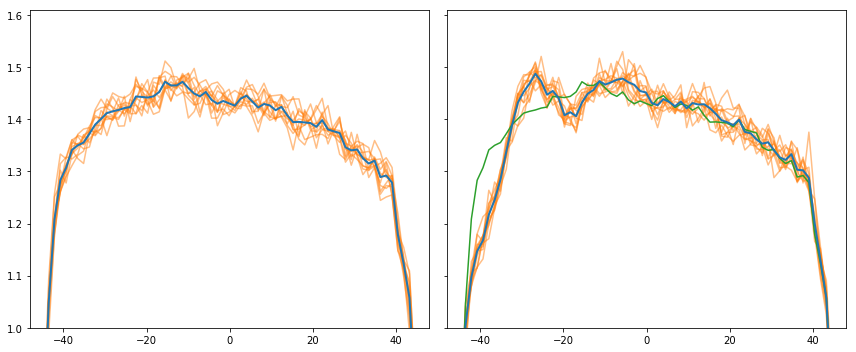

In [468]:
# Collection of 1D profiles 

fig, ax = plt.subplots(ncols=2, figsize=[12, 5], sharey=True, sharex=True)
z = movie_dN[1]

for p in df_bg.profile:
    ax[0].plot(z, p, 'C1', alpha=0.5)
ax[0].plot(z, np.mean(df_bg.profile, axis=0), linewidth=2)

for p in df_data.profile:
    ax[1].plot(z, p, 'C1', alpha=0.5)
ax[1].plot(z, np.mean(df_bg.profile, axis=0), 'C2')
ax[1].plot(z, np.mean(df_data.profile, axis=0), linewidth=2)
ax[1].set(ylim=[1, None], xlim=[-48, 48])
plt.tight_layout()

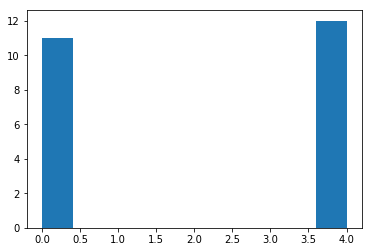

In [469]:
plt.hist(np.concatenate([df_data.x, df_bg.x]));
# plt.figure(figsize=[3,5])
# plt.pcolor(movie_dN[2],)
# plt.pcolor(np.mean([im.app[roi] for im in df_data.image], axis=0) - np.mean([im.app[roi] for im in df_bg.image], axis=0), )

# for i in range(movie_dN[2].shape[1]):
#     plt.plot(movie_dN[1], movie_dN[2][:,i]) 

## Special Plots 

In [181]:
# # Special Waterfall plot  

# plt.figure(figsize=[10, 4])
# plt.subplot(122)
# diff = 0.1
# plt.plot(movie_dN[1], movie_dN[2][:,1] + diff * 0)
# plt.axhline(diff * 0, c='C0', linestyle='--')
# plt.plot(movie_dN[1], movie_dN[2][:,3] + diff * 1)
# plt.axhline(diff * 1, c='C1', linestyle='--')
# plt.plot(movie_dN[1], movie_dN[2][:,5] + diff * 2)
# plt.axhline(diff * 2, c='C2', linestyle='--')
# plt.plot(movie_dN[1], movie_dN[2][:,7] + diff * 3)
# plt.axhline(diff * 3, c='C2', linestyle='--')
# plt.title('# Cycles = 1, 2, 3, 4')

# plt.subplot(121)
# diff = 0.1
# plt.plot(movie_dN[1], movie_dN[2][:,0] + diff * 0)
# plt.axhline(diff * 0, c='C0', linestyle='--')
# plt.plot(movie_dN[1], movie_dN[2][:,2] + diff * 1)
# plt.axhline(diff * 1, c='C1', linestyle='--')
# plt.plot(movie_dN[1], movie_dN[2][:,4] + diff * 2)
# plt.axhline(diff * 2, c='C2', linestyle='--')
# plt.plot(movie_dN[1], movie_dN[2][:,6] + diff * 3)
# plt.axhline(diff * 3, c='C2', linestyle='--')
# plt.title('# Cycles = 0.5, 1.5, 2.5, 3.5')

# plt.tight_layout()

## Save/Load

In [ ]:
# Save Data 

try: WID_SaveAnalyzedDataBtn.on_click(clicked, remove=True)
except: pass

def clicked(btn):
    fname = WID_DatasetType.value + '_' + WID_DatasetDate.value + '_' + WID_DatasetName.value + '_Ver' + __ver__ + '.p'
    p = os.path.join(WID_Folder.value, fname)
    print("Storing File == '{}'".format(p))
    pickle.dump([info, movie_dN, movie_dN_N], open( p, "wb" ) )
    print('Done')
WID_SaveAnalyzedDataBtn.on_click(clicked, remove=False)

display(WID_Folder)
display(WID_DatasetType)
display(WID_DatasetDate)
display(WID_DatasetName)
display(WID_SaveAnalyzedDataBtn)

# Pickle Load
# info, movie_dN, movie_dN_N = pickle.load( open( "20170622_DS3.p", "rb" ) )

In [ ]:
# Load Data -- Single 
data_filename = os.path.join('AnalyzedData','InsituShakingVsFreq_06_22_2017_DS3_Ver01.p') # 71.2
data_filename = os.path.join('AnalyzedData','InsituShakingVsFreq_07_10_2017_DS1_Ver01.p') # 96
# data_filename = os.path.join('AnalyzedData','InsituShakingVsFreq_07_11_2017_DS1_Ver01.p') # 76
# data_filename = os.path.join('AnalyzedData','InsituShakingVsFreq_07_11_2017_DS2_Ver01.p') # 85.9
info, movie_dN, movie_dN_N = pickle.load( open( data_filename, "rb" ) )

# Find approximate 1st mode freq or provide it manually 
res_freq_guess = 85.9

In [ ]:
# Copy to Excel -- Commented Out 

# x_, y_, z_ = movie_dN
# pd.DataFrame(z_, columns=x_, index=y_).to_clipboard(excel=True,)

# x_, y_, z_ = movie_dN_N
# pd.DataFrame(z_, columns=x_, index=y_).to_clipboard(excel=True,)

# pd.DataFrame.from_items([(k,[v]) for k,v in info.items()]).to_clipboard(excel=True)

In [ ]:
# Controllers for clim 
display(WID_clim_dN)
display(WID_clim_dN_N)

## Fourier Transforms

In [ ]:
# Only need info, movie_dN, movie_dN_N for futher process 

In [ ]:
# Spatial FFT Only 

# Data to use 
x, y, z = movie_dN_N
cmap = 'bwr'
xlabel = WID_xlabel.value

# Crop data to end boundaries at the box
L = info['Box Length Fit']
cut = slice(np.argwhere(y<-L/2*1e6)[-1,0]+1, np.argwhere(y>L/2*1e6)[0,0])
y = y[cut]
z = z[cut, :]

# functions 
def compute_k(data, pos):
    return 2*np.pi*np.fft.rfftfreq(data.size, pos[1] - pos[0])
def compute_single_column(data):
    return np.abs(np.fft.rfft(data.flatten()))

# Compute FFT
k = compute_k(z[:,0], y*1e-6)
k_converter = L / np.pi 
z_fft = np.array([compute_single_column(z[:, i]) for i in range(x.size)]).T
movie_1DFFT = (x, k * k_converter, z_fft)

# Plot 
fig, ax = plt.subplots(figsize=[15, 8], nrows=2, sharex=True)
ax[0].pcolormesh(*mesh_for_2d_plot(x, y, z), edgecolor='face', cmap=cmap, vmin=- WID_clim_dN.value , vmax=WID_clim_dN.value)
ax[0].set_ylabel('Position (um)', fontsize=fontsize)
ax[1].pcolormesh(*mesh_for_2d_plot(*movie_1DFFT), edgecolor='face', cmap=cmap)
ax[1].set_xlabel(xlabel, fontsize=fontsize)
ax[1].set_ylabel(r"Wavevector ($\pi$/L)", fontsize=fontsize)
ax[1].set_ylim([0, 17])
ax[1].set_xlim([0,None])

plt.subplots_adjust(hspace=0.03)
plt.tight_layout()
plt.show()

In [ ]:
# Spatial FT Only 

# Data to use 
x, y, z = movie_dN_N
cmap = 'bwr'
xlabel = WID_xlabel.value

# Crop data to end boundaries at the box
L = info['Box Length Fit']
using = 1
cut = slice(np.argwhere(y<-L*using/2*1e6)[-1,0]+1, np.argwhere(y>L*using/2*1e6)[0,0])
y = y[cut]
z = z[cut, :]

# functions 
k = np.arange(0, 20 * np.pi/L , 0.1 * np.pi / L)
k_converter = L / np.pi 
def compute_single_column(data, pos):
    data = data.flatten()
    pos = pos.flatten()
    return np.abs(np.array([np.trapz(data * np.exp(-1j * ki * pos) , pos) for ki in k]))

# Compute FFT
z_fft = np.array([compute_single_column(z[:, i], y*1e-6) for i in range(x.size)]).T
movie_1DFFT = (x, k * k_converter, z_fft)

# Plot 
fig, ax = plt.subplots(figsize=[15, 10], nrows=2, sharex=True)
ax[0].pcolormesh(*mesh_for_2d_plot(x, y, z), edgecolor='face', cmap=cmap, vmin=- WID_clim_dN.value , vmax=WID_clim_dN.value)
ax[0].set_ylabel('Position (um)', fontsize=fontsize)
ax[0].set_title('Fixed Length from erf fit : {:.1f} um'.format(L*1e6) , fontsize=fontsize)
ax[1].pcolormesh(*mesh_for_2d_plot(*movie_1DFFT), edgecolor='face', cmap=cmap)
ax[1].set_xlabel(xlabel, fontsize=fontsize)
ax[1].set_ylabel(r"Wavevector ($\pi$/L)", fontsize=fontsize)
ax[1].set_ylim([0, 17])
ax[1].set_xlim([0,None])
for ymaj in ax[1].yaxis.get_majorticklocs():
    ax[1].axhline(y=ymaj,ls='--', c='w', alpha=0.9)

plt.subplots_adjust(hspace=0.03)
plt.tight_layout()
plt.show()

In [ ]:
# Fits for shaking vs frequency at N or N+1/4 cycles 

# Functions 
def sho_phase(f, f0, gamma):
    f = f * twopi
    f0 = f0 * twopi
    gamma = gamma * twopi
    return np.mod(np.arctan((gamma * f) / (f0**2 - f**2)), np.pi)

def sho_amp(f, f0, gamma, X0=1):
    f = f * twopi
    f0 = f0 * twopi
    gamma = gamma * twopi
    return (f0**2 * X0) / ((f0**2 - f**2)**2 + (gamma*f)**2)**(1/2)

def sho_response(f, f0, gamma, X0, N):
    return sho_amp(f, f0, gamma, X0) * np.sin(twopi * N - sho_phase(f, f0, gamma))

def fitfun_single_abs(f, f0, gamma, X0):
    return sho_response(f, f0, gamma, X0, N=0)

def fitfun_single_dis(f, f0, gamma, X0):
    return sho_response(f, f0, gamma, X0, N=0.25)

def fitfun_all_even_sep_abs(f, a0 = 0, f2=100, g2=10, x2=0, f4=200, g4=10, x4=0, f6=300, g6=10, x6=0, f8=400, g8=10, x8=0, f10=500, g10=10, x10=0, f12=600, g12=10, x12=0):
    y = fitfun_single_abs(f, f2, g2, x2) + fitfun_single_abs(f, f4, g4, x4) + fitfun_single_abs(f, f6, g6, x6) + fitfun_single_abs(f, f8, g8, x8) + fitfun_single_abs(f, f10, g10, x10) + fitfun_single_abs(f, f12, g12, x12)
    return y + a0

def fitfun_all_even_sep_dis(f, a0 = 0, f2=100, g2=10, x2=0, f4=200, g4=10, x4=0, f6=300, g6=10, x6=0, f8=400, g8=10, x8=0, f10=500, g10=10, x10=0, f12=600, g12=10, x12=0):
    y = fitfun_single_dis(f, f2, g2, x2) + fitfun_single_dis(f, f4, g4, x4) + fitfun_single_dis(f, f6, g6, x6) + fitfun_single_dis(f, f8, g8, x8) + fitfun_single_dis(f, f10, g10, x10) + fitfun_single_dis(f, f12, g12, x12)
    return y + a0

def fitfun_all_even_sep_select(*args, **kwargs):
    return fitfun_all_even_sep_abs(*args, **kwargs)
#     return fitfun_all_even_sep_dis(*args, **kwargs)

In [ ]:
# Fit 
xlabel = WID_xlabel.value
clim = WID_clim_dN_N.value
ylabel = 'Response (%)'
fontsize = 15

# Extract data 
x, y, z = movie_dN_N

# central cut 
center = np.argwhere(np.abs(y) == np.min(np.abs(y)))[0,0]
slicer = slice(center - 2, center + 1)
central_cut = tp.Curve(x = x, y = 100 * np.mean(z[slicer, :], 0))
central_cut.removenan()

# Fit central data 
guess = [2, 
         res_freq_guess * 2 , 15 , +2, 
         res_freq_guess * 4 , 50 , -2, 
         res_freq_guess * 6 , 50 , +1.5, 
#          res_freq_guess * 8 , 100 , -1.0, 
#          res_freq_guess * 10, 150 , +0.2, 
#          res_freq_guess * 12, 250, -0.1, 
        ]
fr, fe = central_cut.fit(fitfun_all_even_sep_select, guess, plot=False, xlim=[res_freq_guess*1.25*0, np.inf])
a0 = fr[0]
fr = fr[1:]
fe = fe[1:]
guess = guess[1:]
mode_num = np.arange(0, 2*len(guess)//3, 2) + 2 
fit_sho_all_freq = [mode_num, np.array(fr[0::3]), np.array(fe[0::3])]
fit_sho_all_gamma = [mode_num, np.array(fr[1::3]), np.array(fe[1::3])]
fit_sho_all_amp = [mode_num, np.abs(np.array(fr[2::3])), np.array(fe[2::3])]
fit_sho_all_freq_0 = [mode_num, fit_sho_all_freq[1] / fit_sho_all_freq[0], fit_sho_all_freq[2] / fit_sho_all_freq[0], ]

# Plot 
fig = plt.figure(figsize=[15, 10])
ax1 = plt.subplot(211)
plt.pcolormesh(*mesh_for_2d_plot(x, y, z), vmin=-clim, vmax=clim, cmap='bwr')
plt.axhline(y[slicer.start], c='w', linestyle='--')
plt.axhline(y[slicer.stop-1], c='w', linestyle='--')
plt.ylabel('Position (um)', fontsize=fontsize)
ax2 = plt.subplot(212, sharex=ax1)
plt.axhline(0, c='k', linestyle='-')
plt.axhline(a0, c='k', linestyle='--')
plt.plot(*central_cut.data, '.-')
plt.plot(*central_cut.xyfitplot)
plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.xlim([x.min(), x.max()])
plt.tight_layout()

# Plot Fit results
fig = plt.figure(figsize=[15,4])
plt.subplot(131)
plt.errorbar(*fit_sho_all_freq_0, fmt='o')
plt.xlim([0,None])
plt.ylabel('Fundamental Frequency (Hz)', fontsize=fontsize)
plt.subplot(132)
plt.errorbar(*fit_sho_all_gamma, fmt='o')
plt.xlim([0,None])
plt.ylim([0, None])
plt.ylabel('Gamma (Hz)', fontsize=fontsize)
plt.subplot(133)
plt.errorbar(*fit_sho_all_amp, fmt='o')
plt.xlim([0,None])
plt.ylim([0, None])
plt.ylabel('Driving Amplitude (Arb)', fontsize=fontsize)
plt.tight_layout()

## Tests

In [ ]:
# Sum(dN^2)

# Extract data 
x, y, z = movie_dN

# Crop data to end boundaries at the box
L = info['Box Length Fit'] * 0.8
cut = slice(np.argwhere(y<-L/2*1e6)[-1,0]+1, np.argwhere(y>L/2*1e6)[0,0])
y = y[cut]
z = z[cut, :]

# Direct sum of dN
_ = - np.mean(z, axis=0)
direct_sum = tp.Curve(x.flatten(), _.flatten())

# Squared sum of dN
_ = (np.mean(z**2, axis=0))**(1/2)
squared_sum = tp.Curve(x.flatten(), _.flatten())

# Fit sum of lorentzians 
def fitfun_lorentzian_sum(f, offset=0, f1=100, g1=1, a1=0, f2=100, g2=1, a2=0, f3=100, g3=1, a3=0, f4=100, g4=1, a4=0, f5=100, g5=1, a5=0, f6=100, g6=1, a6=0):
    return offset + lorentzian_fitfun(f, f1, g1, a1) + lorentzian_fitfun(f, f2, g2, a2) + lorentzian_fitfun(f, f3, g3, a3) + lorentzian_fitfun(f, f4, g4, a4) + lorentzian_fitfun(f, f5, g5, a5) + lorentzian_fitfun(f, f6, g6, a6)

c = squared_sum
res_freq = res_freq_guess
guess = [c.y.mean(),
         res_freq*2, 10, c.y.max()/1,
         res_freq*4, 30, c.y.max()/2,
         res_freq*6, 50, c.y.max()/4,
#          res_freq*8, 80, c.y.max()/6,
#          res_freq*10, 80, c.y.max()/8,
#          res_freq*12, 100, c.y.max()/10,
        ]
fr, fe = c.fit(fitfun_lorentzian_sum, guess, plot=True, xlim=[100, np.inf])

# Extract Results 
mode_num = (np.arange((len(fr)-1)//3) + 1) * 2
freq = [mode_num, fr[1:][0::3], fe[1:][0::3]]
freq0 = [freq[0], freq[1]/mode_num, freq[2]/mode_num]
gamma = [mode_num, fr[1:][1::3], fe[1:][1::3]]
amp = [mode_num, fr[1:][2::3], fe[1:][2::3]]
offset = [fr[0], fr[0]-fe[0], fr[0]+fe[0]]
offset_plot = [x, x*0 + offset[1], x*0 + offset[2]]

# Plot Results 
fig = plt.figure(figsize=[15, 10])
ax1 = plt.subplot(211)
plt.pcolormesh(*mesh_for_2d_plot(x, y, z), vmin=-clim, vmax=clim, cmap='bwr')
plt.ylabel('Position (um)', fontsize=fontsize)
ax2 = plt.subplot(212, sharex=ax1)
plt.axhline(offset[0], c='k', linestyle='-')
plt.fill_between(*offset_plot, color='k', alpha=0.1)
plt.plot(*c.data, '.-')
plt.plot(*c.xyfitplot)
plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.xlim([x.min(), x.max()])
plt.tight_layout()

# Plot results 
fig = plt.figure(figsize=[15,4])
plt.subplot(131)
plt.errorbar(*freq0, fmt='o')
plt.xlim([0,mode_num[-1]+2])
plt.ylabel('Fundamental Frequency (Hz)', fontsize=fontsize)
plt.subplot(132)
plt.errorbar(*gamma, fmt='o')
plt.xlim([0,mode_num[-1]+2])
plt.ylim([0, None])
plt.ylabel('Gamma (Hz)', fontsize=fontsize)
plt.subplot(133)
plt.errorbar(*amp, fmt='o')
plt.xlim([0,mode_num[-1]+2])
plt.ylim([0, None])
plt.ylabel('Amplitude (Arb)', fontsize=fontsize)
plt.tight_layout()

In [ ]:
# Plot Results 
fig = plt.figure(figsize=[6, 8])
ax1 = plt.subplot(311)
plt.pcolormesh(*mesh_for_2d_plot(x, y, z), vmin=-clim, vmax=clim, cmap='bwr')
ax2 = plt.subplot(312, sharex=ax1)
plt.plot(*c.data, '.-')
ax3 = plt.subplot(313, sharex=ax1)
plt.pcolormesh(*mesh_for_2d_plot(*movie_1DFFT), edgecolor='face', cmap=cmap)
width = 20
center = res_freq_guess
plt.xlim([center-width, center+width])
plt.ylim([0, 5])
plt.tight_layout()

In [ ]:
# Spatial FT Only 

# Data to use 
x, y, z = movie_dN
cmap = 'bwr'
xlabel = WID_xlabel.value

# Crop data to end boundaries at the box
L = info['Box Length Fit'] * 1e6

# Plot 
fig, ax = plt.subplots(figsize=[10, 5], nrows=1, sharex=True)
ax.pcolormesh(*mesh_for_2d_plot(x, y, z), edgecolor='face', cmap=cmap, vmin=- WID_clim_dN.value , vmax=WID_clim_dN.value)
ax.set_ylabel('Position (um)', fontsize=fontsize)
ax.set_title(r'$\Delta$N' , fontsize=fontsize)
ax.axhline(L/2, c='k', linestyle='-', alpha=0.8)
ax.axhline(-L/2, c='k', linestyle='-', alpha=0.8)
plt.tight_layout()
plt.show()

# Energy Spectroscopy

# Additional

## Temporary Data Collection 

In [451]:
# collector = dict()

In [579]:
datasets = ['7C','7D','8A','8B','8C','8D','8E','8F','8G','8H']
datasets = ['7C','8A','8B','8C','8D','8E','8F','8G','8H']
heatcycles = np.array([0,80,35,20,50,40,10,0,30,25])
heatcycles = np.array([0,35,20,50,40,10,0,30,25])

In [580]:
collector['8H'] = movie_dN

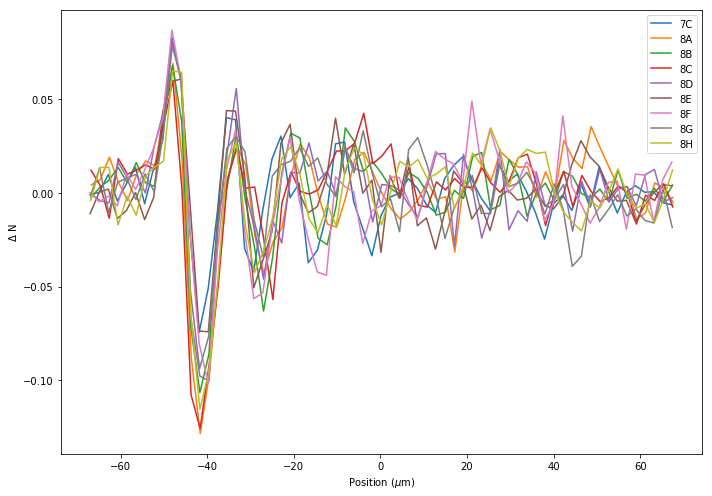

In [581]:
plt.figure(figsize=[10, 7])
for ds in datasets:
    x, y, z = collector[ds]
    plt.plot(y, z, label=ds)
plt.legend()
plt.ylabel(r'$\Delta$ N')
plt.xlabel(r'Position ($\mu$m)')
plt.tight_layout()

In [236]:
def fitfun_sin_decay(x, x0, wavelength, amp=1, phase = 0, offset=0, slope=0):
    return np.exp(-x/x0) * amp * np.sin(2*np.pi/wavelength * x - phase) + offset + slope*x

##______Fit Value______Error______
 0 ==>     9.421 (+-)     2.536
 1 ==>     14.35 (+-)     1.117
 2 ==> -0.001509 (+-)  0.001558
 3 ==>     5.835 (+-)     1.188
 4 ==> -0.0008789 (+-)  0.002685


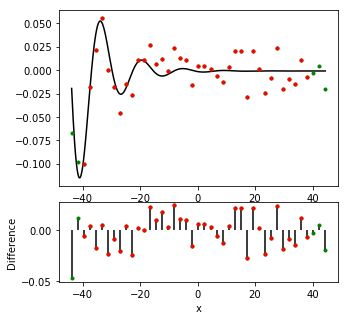

In [587]:
test = '8D'
guess = [33, 15, 0.01, 0, 0.01]
c = tp.Curve(collector[test][1].flatten(), collector[test][2].flatten()).trim(xlim=[-45, 45])
fr, fe = c.fit(fitfun_sin_decay, guess, xlim=[-40, 40], plot=True)

In [588]:
frs = []
fes = []
for ds in datasets:
    c = tp.Curve(collector[ds][1].flatten(), collector[ds][2].flatten()).trim(xlim=[-45, 45])
    fr, fe = c.fit(fitfun_sin_decay, guess, xlim=[-40, 40], plot=False)
    frs.append(fr)
    fes.append(fe)
frs = np.array(frs)
fes = np.array(fes)
shaking_freq = 1000

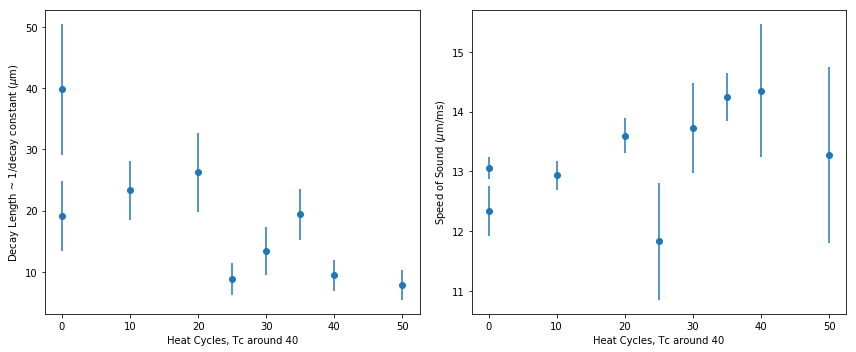

In [589]:
fig, ax = plt.subplots(ncols=2, figsize=[12, 5])
ax[0].errorbar(heatcycles, frs[:, 0], fes[:, 0], fmt = 'o')
ax[0].set(ylabel=r'Decay Length ~ 1/decay constant ($\mu$m)', xlabel='Heat Cycles, Tc around 40')
ax[1].errorbar(heatcycles, shaking_freq * frs[:, 1] * 1e-3, shaking_freq * fes[:, 1] * 1e-3, fmt = 'o')
ax[1].set(ylabel=r'Speed of Sound ($\mu$m/ms)', xlabel='Heat Cycles, Tc around 40')
plt.tight_layout()

In [ ]:
test = '50'
c = tp.Curve(collector[test][1].flatten(), collector[test][2].flatten()).trim(xlim=[-50, 50])
# fr, fe = c.fit(fitfun_sin_decay, [15, 20, 0.005, 0.5], xlim=[-45, 45], plot=True)

# FFT
y = np.fft.fft(c.y)
x = np.fft.fftfreq(c.y.size, c.x[1] - c.x[0]) * twopi
c_fft = tp.Curve(x, y)

# cutoff wavelength 
cutoff_k = twopi / 7
y = c_fft.y.copy()
y[np.abs(c_fft.x) >= cutoff_k] = 0
y[c_fft.x == 0] = 0
c_fft_filter = tp.Curve(c_fft.x, y)

# iFFT
y = np.fft.ifft(c_fft_filter.y)
c_filter = tp.Curve(c.x, np.real(y))

# Plot 
fig, ax = plt.subplots(ncols=2, figsize=[10, 4])
ax[0].plot(*c_fft.data)
ax[0].plot(*c_fft_filter.data)
ax[1].plot(*c.data)
ax[1].plot(*c_filter.data)
plt.tight_layout()

##______Fit Value______Error______
 0 ==>     87.96 (+-)     16.12
 1 ==>     29.48 (+-)    0.2861
 2 ==>   0.05216 (+-)  0.002223
 3 ==>     7.287 (+-)   0.04199


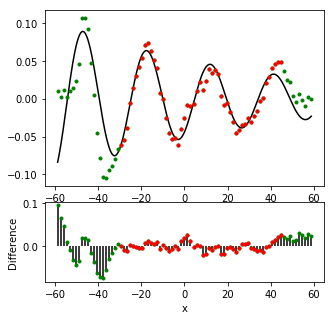

In [239]:
c = tp.Curve(movie_dN[1].flatten(), movie_dN[2].flatten()).trim(xlim=[-60, 60])
fr, fe = c.fit(fitfun_sin_decay, [80, 30, 0.05, 0,], xlim=[-30,45], plot=True)